In [364]:
# Dependancies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import requests
import time
from pprint import pprint
import gmaps
import gmaps.geojson_geometries
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm

from config import gkey, ckey

state_abbr = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN",
              "IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV",
              "NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN",
              "TX","UT","VT","VA","WA","WV","WI","WY"]

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

## Load crime statistics by state and filter for 2017

In [365]:
# Load crime statistics by state for all years
crime_df = pd.read_csv('data/crime_by_state.csv')

# Filter out all years except for 2017 (the latest). 
crime2017_df = crime_df[crime_df['year'] == 2017]
crime2017_df.head()

,year,state_abbr,state_id,population,aggravated_assault,arson,burglary,homicide,larceny,motor_vehicle_theft,property_crime,rape_legacy,rape_revised,robbery,violent_crime
17,2017,AL,2,4874747,18902,703.0,31477,404,99842,12841,144160,0,2028.0,4217,25551
56,2017,AK,1,739795,4257,139.0,4171,62,17775,4258,26204,0,863.0,951,6133
103,2017,AZ,5,7016270,24207,1183.0,37627,416,147830,19058,204515,0,3581.0,7440,35644
119,2017,AR,3,3004279,12425,534.0,21862,258,63374,7253,92489,0,2053.0,1935,16671
161,2017,CA,6,39536653,104454,8648.0,176690,1830,642033,168391,987114,0,14721.0,56622,177627


## Crime statistics per 100 people

- Remove all columns except 'violent crime' and 'property crime'
- Normalize by state population
- Sort dataframe to see top five and bottom five states
- Create a list of five worst and five best states for agency data requests

In [366]:
crime2017_df = crime2017_df[['state_abbr', 'violent_crime', 'property_crime', 'population']]
crime2017_df['violent_crime_per100'] = crime2017_df['violent_crime']*100/crime2017_df['population']
crime2017_df['property_crime_per100'] = crime2017_df['property_crime']*100/crime2017_df['population']
crime2017_df['total_crime_per100'] = crime2017_df['violent_crime_per100']+crime2017_df['property_crime_per100']
crime2017_df.head()

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
17,AL,25551,144160,4874747,0.524150,2.957282,3.481432
56,AK,6133,26204,739795,0.829013,3.542062,4.371076
103,AZ,35644,204515,7016270,0.508019,2.914868,3.422887
119,AR,16671,92489,3004279,0.554909,3.078576,3.633484
161,CA,177627,987114,39536653,0.449272,2.496706,2.945978


## Five states with highest crime rates

In [367]:
top_five= crime2017_df.sort_values(by = ['total_crime_per100'], ascending = False)[:5]
top_five

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
1171,NM,16359,82306,2088070,0.783451,3.941726,4.725177
56,AK,6133,26204,739795,0.829013,3.542062,4.371076
682,LA,26092,157712,4684333,0.557006,3.366797,3.923803
1522,SC,25432,160575,5024369,0.506173,3.195924,3.702097
119,AR,16671,92489,3004279,0.554909,3.078576,3.633484


## Five states with lowest crime rates

In [368]:
bottom_five = crime2017_df.sort_values(by = ['total_crime_per100'], ascending = True)[:5]
bottom_five

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
1093,NH,2668,18555,1342795,0.198690,1.381819,1.580509
1734,VT,1034,8960,623657,0.165796,1.436687,1.602483
721,ME,1617,20133,1335907,0.121041,1.507066,1.628107
1132,NJ,20604,140086,9005644,0.228790,1.555536,1.784325
781,MA,24560,98575,6859819,0.358027,1.436991,1.795018


### List of 5 states with highest crime rates and 5 states with lowest crime rates

In [369]:
wb_df = top_five.append(bottom_five).reset_index(drop = True)
wb_df.head(10)

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
0,NM,16359,82306,2088070,0.783451,3.941726,4.725177
1,AK,6133,26204,739795,0.829013,3.542062,4.371076
2,LA,26092,157712,4684333,0.557006,3.366797,3.923803
3,SC,25432,160575,5024369,0.506173,3.195924,3.702097
4,AR,16671,92489,3004279,0.554909,3.078576,3.633484
5,NH,2668,18555,1342795,0.198690,1.381819,1.580509
6,VT,1034,8960,623657,0.165796,1.436687,1.602483
7,ME,1617,20133,1335907,0.121041,1.507066,1.628107
8,NJ,20604,140086,9005644,0.228790,1.555536,1.784325
9,MA,24560,98575,6859819,0.358027,1.436991,1.795018


## Stacked bar chart of crime rates for five worst/five best states

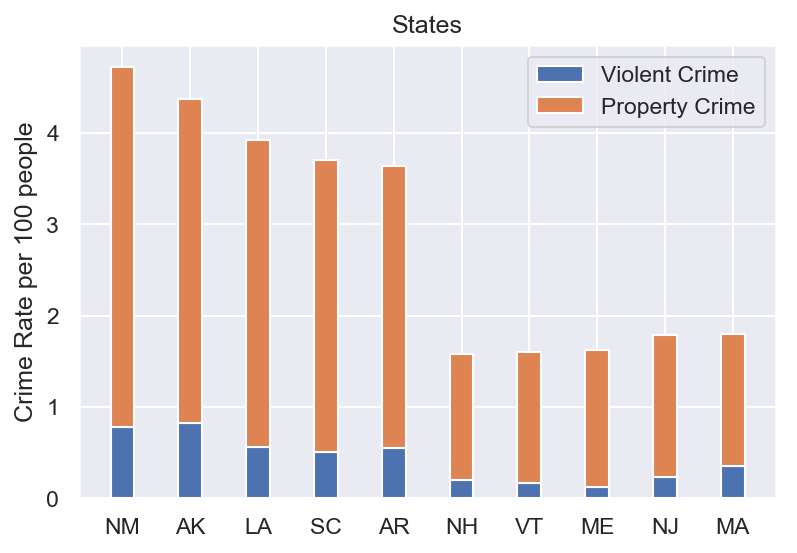

In [370]:
state_labels = list(wb_df['state_abbr'])
rng = np.arange(len(wb_df))

plt.figure(dpi = 150)
width = 0.35       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(wb_df.index, wb_df['violent_crime_per100'],width, label = 'Violent Crime')
p2 = plt.bar(wb_df.index, wb_df['property_crime_per100'], width, bottom = wb_df['violent_crime_per100'], label = 'Property Crime')
plt.ylabel('Crime Rate per 100 people')
plt.title('States')
plt.xticks(rng, state_labels)
plt.legend()
plt.show()

## List of 5 states with highest crime rates and lowest crme rates

In [371]:
worst = list(top_five['state_abbr'])
best = list(bottom_five['state_abbr'])
worst_best = worst+best
worst_best

['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [372]:
states_full = ['New Mexico', 'Alaska', 'Louisiana', 'South Carolina', 'Arkansas', 
          'New Hampshire', 'Vermont', 'Maine', 'New Jersey', 'Massachusetts']

## Prepare state data for mapping

- Create a normalized colormap
- Update the state dataframe to add two missing territories (DC and Puerto Rico) 
- Turn the colormap into an list of hex colors, based on the level of crime
- Load states geometry from gmaps
- Plot

In [373]:
max_crime = max(crime2017_df['total_crime_per100'])
crime_val = crime2017_df['total_crime_per100']/max(crime2017_df['total_crime_per100'])
crime_val = crime_val.tolist()

In [374]:
norm = colors.Normalize(vmin=min(crime_val), vmax = max(crime_val))

m = cm.ScalarMappable(norm = norm, cmap='OrRd')
colormap = m.to_rgba(crime_val)
clr = [colors.to_hex(c) for c in colormap]

colorcoded_states = pd.Series(clr, index = crime2017_df['state_abbr'])
colorcoded_states = colorcoded_states.to_frame()

# Create a dictionary of state's abbreviated names as keys and full names as values
state_dict = dict(zip(state_abbr, states))

state_names = pd.Series(states, index = state_abbr)
state_names = state_names.to_frame()

state_color = colorcoded_states.merge(state_names, right_index = True, left_index = True)
state_color = state_color.rename(index=str, columns={"0_x": "color", "0_y": "state"})

## Map crime rates by state using gmaps

In [375]:
states_geo = gmaps.geojson_geometries.load_geometry('us-states')

# get list of states as they are ordered in gmaps
st = [i['properties']['NAME'] for i in states_geo['features']]

# find territories, missing in the original dataframe and present in the 'us-states' geojson file
missing = [s for s in st if s not in states]

# Add the territories to the frame and color them white 
missing_df = pd.DataFrame([['#ffffff', missing[0]], ['#ffffff', missing[1]]], columns=list(state_color), index = ['DC', 'PR'])
state_color = state_color.append(missing_df)
state_order = pd.DataFrame(pd.Series(st), columns = ['state'])

# create a state-color dataframe for geojson layer
df = state_order.merge(state_color, on = 'state')



# Create a layer for color coded states
gmaps.configure(api_key = gkey)
fig = gmaps.figure()
states_layer = gmaps.geojson_layer(states_geo, 
                                   fill_color = list(df['color']))
fig.add_layer(states_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Map all mass shooting incidents reported between 2014 and 2019

In [376]:
shootings = pd.read_csv('data/shootings_all_years.csv')
shootings['Total Victims Count'] = shootings['# Killed'] + shootings['# Injured']
most_victims = shootings.sort_values(by = ['Total Victims Count'], ascending = False)
most_victims.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,state_abbr,lat,lon,Year,Total Victims Count
1056,"October 1, 2017",Nevada,Las Vegas,3950 Las Vegas Blvd S,59,441,NaN,NV,36.093392,-115.176337,2017,500
849,"June 12, 2016",Florida,Orlando,1912 S Orange Avenue,50,53,NaN,FL,28.519612,-81.376846,2016,103
1022,"November 5, 2017",Texas,Sutherland Springs,216 4th St,27,20,NaN,TX,29.273218,-98.056343,2017,47
286,"December 2, 2015",California,San Bernardino,1365 South Waterman Avenue,16,19,NaN,CA,34.075564,-117.277623,2015,35
1642,"February 14, 2018",Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17,NaN,FL,26.304503,-80.269457,2018,34


In [377]:
locations = [tuple(coord) for coord in shootings[['lat', 'lon']].values]
victims = list(shootings['Total Victims Count'])

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights= victims, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 100
heat_layer.point_radius = 1

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Obtain all agency reports for the top five and bottom five states

Source: FBI Crime Data API, official estimates fron the Universal Crime Reports (UCR), compiled and published by FBI  
Time range: 2014 - 2017

- Read a list of agencies from .csv file
- Filter the list to exclude the states which are not in the top of bottom five
- Request all reports from agencies in  ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA'] states
- Save all reports as a .csv file fr future use
- Read into a dataframe and clean it (group by year and county, sum up all violent crime and property crime)
- Save as a new csv file

In [378]:
# Read a list of a
agencies = pd.read_csv('data/agencies.csv')
agencies_df = agencies[agencies['State'].isin(worst_best)].reset_index()

# export_csv = reports_df.to_csv (r'data/reports_by_agency_10states.csv', index = None, header=True)

## Request crime reports from law enforcemen agencies in 5 worst and 5 best states:
### NM, AK, LA, SC, AR, NH, VT, ME, NJ, MA

In [379]:

def reports_by_agency(agencies_df):
    # Collects all Uniform Crime Reports law enforcement agencies in dataframe agences_df
    # Request rate is limited to 1000 requests per hour
    reports_by_agency = []

    num = len(agencies_df)
    count = 0
    for i in range(2926, num):

        ori = agencies_df['Agency ORI9'][i]

        try:
            query_url = f'https://api.usa.gov/crime/fbi/sapi/api/summarized/agencies/{ori}/offenses/2014/2017?api_key={ckey}'
            response = requests.get(query_url)
            print('==========================================')
            print(f'Requesting report from agency {ori}')
            count +=1
            result = response.json()
            report_dict = result['results']
            print(f'Adding {i} report of {num} | agency ORI9 is {ori} | Request count {count}')
            reports_by_agency.append(pd.DataFrame(report_dict))
        except:
            print('............................................')
            print(f'Something went wrong, skipping agency {ori}...')
    return reports_by_agency
           
# reports_by_agency = reports_by_agency(agencies_df)

# reports_df = reports_by_agency[0].append(reports_by_agency[1:], ignore_index = True)
# export_csv = reports_df.to_csv (r'data/reports_by_agency_10states_3.csv', index = None, header=True)

# files = ['data/reports_by_agency_10states.csv',
#         'data/reports_by_agency_10states_1.csv',
#         'data/reports_by_agency_10states_2.csv',
#         'data/reports_by_agency_10states_3.csv']

# dfObj = []

# for file in files:
#     df = pd.read_csv(file)
#     dfObj.append(df)
    
# allreports = dfObj[0].append(dfObj[1:], ignore_index = True)
# allreports = allreports.rename(index = str, columns = {'ori': 'Agency ORI9'})
# allreports = allreports.merge(agencies_df, how = 'left')
# # export_csv = allreports.to_csv (r'data/all_agency_reports_10states.csv', index = None, header=True)

In [380]:
allreports = pd.read_csv('data/crime_by_county2017_10states.csv')
allreports.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr
0,Alaska,aleutians,2017,5432,1212,739795,AK
1,Alaska,anchorage,2017,762,64,739795,AK
2,Alaska,bethel,2017,127,15,739795,AK
3,Alaska,bristol,2017,16380,3601,739795,AK
4,Alaska,dillingham,2017,76,2,739795,AK


## Aggregate all state and county level data

### By state
- add population by state
- add household income by state
- gyms by state (10 states only)

### By county

- add population by county
- add household income
- gyms by state (10 states only)

### Load crime statistics for 2017 for the 10 states ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [383]:
crime_county_2017 = pd.read_csv('data/crime_by_county2017_10states.csv')
crime_county_2017 .head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr
0,Alaska,aleutians,2017,5432,1212,739795,AK
1,Alaska,anchorage,2017,762,64,739795,AK
2,Alaska,bethel,2017,127,15,739795,AK
3,Alaska,bristol,2017,16380,3601,739795,AK
4,Alaska,dillingham,2017,76,2,739795,AK


In [209]:
# export_csv = aggregated_2017.to_csv(r'data/crime_by_county2017_10states.csv', index = None, header=True)

### Load crime data for 2017 per county ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [210]:
df_crime = pd.read_csv('data/crime_by_county2017_10states.csv')
df_crime.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr
0,Alaska,aleutians,2017,5432,1212,739795,AK
1,Alaska,anchorage,2017,762,64,739795,AK
2,Alaska,bethel,2017,127,15,739795,AK
3,Alaska,bristol,2017,16380,3601,739795,AK
4,Alaska,dillingham,2017,76,2,739795,AK


### Load hospital count per county ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [384]:
df_hospitals = pd.read_csv('data/hospital_county.csv')
df_hospitals['index'] = df_hospitals['index'].apply(lambda x: x.lower())
df_hospitals = df_hospitals.rename(index = str, columns = {'index': 'County', 'COUNTY': 'Hospital count'})
df_hospitals['County'] = df_hospitals['County'].apply(lambda x: x.split()[0])
df_hospitals.head()

,County,Hospital count
0,los,131
1,harris,108
2,jefferson,94
3,montgomery,78
4,cook,75


### Load gym counts per county ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [212]:
df_gym = pd.read_csv('data/county gym count.csv', header = None)
df_gym [1] = df_gym [1].apply(lambda x: x.lower())
df_gym = df_gym.rename(columns = {0: 'State', 1: 'County', 2:'Gym count'})
df_gym['County'] = df_gym['County'].apply(lambda x: x.split(' ')[0])
df_gym.head()

,State,County,Gym count
0,AK,aleutians,0.0
1,AK,aleutians,0.0
2,AK,anchorage,98.0
3,AK,bethel,0.0
4,AK,bristol,0.0


In [213]:
df_agencies = pd.read_csv('data/agencies.csv')
df_agencies['County'] = df_agencies['County'].apply(lambda x: x.strip().lower())
df_agencies['State'] = df_agencies['State'].apply(lambda x: x.strip())
df_agencies.head()

,State,County,County FIPS,Agency Name,Agency ORI9
0,AL,autauga,1.0,AUTAUGA COUNTY SHERIFF'S OFFICE,AL0040000
1,AL,baldwin,3.0,AUTAUGAVILLE POLICE DEPARTMENT,AL0040200
2,AL,barbour,5.0,PRATTVILLE POLICE DEPARTMENT,AL0040100
3,AL,autauga,1.0,BALDWIN COUNTY SHERIFF'S OFFICE,AL0050000
4,AL,baldwin,3.0,BAY MINETTE POLICE DEPARTMENT,AL0050100


### Load unemployment rates per county ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [385]:
states = ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

df_unemployment = pd.read_csv('data/county_state_by_unemployment_rate.csv')
df_unemployment['County'] = df_unemployment['County'].apply(lambda x: x.split(' ')[0].lower().strip())
df_unemployment['State'] = df_unemployment['State'].apply(lambda x: str(x).strip())
df_unemployment = df_unemployment[df_unemployment['State'].isin(states)]
df_unemployment.head()

,FIPS,County,State,Unemployment Rate
67,13,aleutians,AK,2.5
68,16,aleutians,AK,3.6
69,20,anchorage,AK,6.0
70,50,bethel,AK,13.8
71,60,bristol,AK,6.3


### Load median household income data

In [387]:
df_income = pd.read_csv('data/list_of_state_and_counties_by_median_income.csv')
df_income['County'] = df_income['County'].apply(lambda x: x.split(' ')[0])
df_income = df_income[df_income['State'].isin(states_full)]
df_income.head()

,State,County,MedianIncome
67,Alaska,north,82500
68,Alaska,dillingham,56089
69,Alaska,kenai,75689
70,Alaska,yukon-koyukuk,46875
71,Alaska,aleutians,87159


### Import county population estimates for 2017

In [388]:
countypop_df = pd.read_csv('data/co-est2017-alldata.csv', encoding = "ISO-8859-1")
countypop_df = countypop_df.filter(['STNAME', 'CTYNAME', 'CENSUS', 'POPESTIMATE2017'], axis = 1)
countypop_10states = countypop_df[countypop_df['STNAME'].isin(states_full)].rename(index = str, 
                                                                                   columns = {'STNAME': 'State', 
                                                                                              'CTYNAME':'County',
                                                                                             'POPESTIMATE2017': 'County Population'})
countypop_10states['County'] = countypop_10states['County'].apply(lambda x: x.split(' ')[0].lower())
countypop_10states.head()
# export_csv = countypop_10states.to_csv(r'data/countypop_10states.csv', index = None, header=True)

,State,County,County Population
68,Alaska,alaska,739795
69,Alaska,aleutians,3370
70,Alaska,aleutians,5763
71,Alaska,anchorage,294356
72,Alaska,bethel,18076


### Merge unemployment, population 

In [396]:
merged_df = df_crime.merge(df_unemployment, how = 'left', left_on=['County','state_abbr'], right_on = ['County', 'State'])
merged_df = merged_df.rename(index = str, columns = {'State_x': 'State'}).drop(columns = ['FIPS', 'State_y'])
merged_df.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr,Unemployment Rate
0,Alaska,aleutians,2017,5432,1212,739795,AK,2.5
1,Alaska,aleutians,2017,5432,1212,739795,AK,3.6
2,Alaska,anchorage,2017,762,64,739795,AK,6.0
3,Alaska,bethel,2017,127,15,739795,AK,13.8
4,Alaska,bristol,2017,16380,3601,739795,AK,6.3


### Merge dataframe with the gym data on County and State 

In [397]:
merged_df = merged_df.merge(df_gym, left_on = ['County', 'state_abbr'], right_on = ['County', 'State'], how = 'left')
merged_df = merged_df.drop_duplicates().reset_index(drop = True)
merged_df = merged_df.drop_duplicates().reset_index(drop = True).drop(columns = ['State_y'])
merged_df = merged_df.rename(index = str, columns = {'State_x': 'State'})
merged_df.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr,Unemployment Rate,Gym count
0,Alaska,aleutians,2017,5432,1212,739795,AK,2.5,0.0
1,Alaska,aleutians,2017,5432,1212,739795,AK,3.6,0.0
2,Alaska,anchorage,2017,762,64,739795,AK,6.0,98.0
3,Alaska,bethel,2017,127,15,739795,AK,13.8,0.0
4,Alaska,bristol,2017,16380,3601,739795,AK,6.3,0.0


### Merge dataframe with the mediam household income dataset on County and State 

In [398]:
merged_df = merged_df.merge(df_income, on = ['State', 'County'])
merged_df.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr,Unemployment Rate,Gym count,MedianIncome
0,Alaska,aleutians,2017,5432,1212,739795,AK,2.5,0.0,87159
1,Alaska,aleutians,2017,5432,1212,739795,AK,2.5,0.0,67750
2,Alaska,aleutians,2017,5432,1212,739795,AK,3.6,0.0,87159
3,Alaska,aleutians,2017,5432,1212,739795,AK,3.6,0.0,67750
4,Alaska,anchorage,2017,762,64,739795,AK,6.0,98.0,90466


### Clean up the data

In [399]:
merged_df = merged_df.drop_duplicates().reset_index(drop = True)
merged_df['County'] = merged_df['County'].apply(lambda x: str(x).strip())
merged_df.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr,Unemployment Rate,Gym count,MedianIncome
0,Alaska,aleutians,2017,5432,1212,739795,AK,2.5,0.0,87159
1,Alaska,aleutians,2017,5432,1212,739795,AK,2.5,0.0,67750
2,Alaska,aleutians,2017,5432,1212,739795,AK,3.6,0.0,87159
3,Alaska,aleutians,2017,5432,1212,739795,AK,3.6,0.0,67750
4,Alaska,anchorage,2017,762,64,739795,AK,6.0,98.0,90466


In [400]:
merged_df = merged_df.drop([0, 1]) 
merged_df = merged_df.reset_index(drop = True)

merged_df = merged_df.drop(['data_year'], axis = 1)
merged_df.head()

# export_csv = merged_df.to_csv(r'data/aggregated2017_10states.csv', index = None, header=True)

,State,County,property-crime,violent-crime,population,state_abbr,Unemployment Rate,Gym count,MedianIncome
0,Alaska,aleutians,5432,1212,739795,AK,3.6,0.0,87159
1,Alaska,aleutians,5432,1212,739795,AK,3.6,0.0,67750
2,Alaska,anchorage,762,64,739795,AK,6.0,98.0,90466
3,Alaska,bethel,127,15,739795,AK,13.8,0.0,53224
4,Alaska,bristol,16380,3601,739795,AK,6.3,0.0,96458


## Add new columns with crime rates per 100 of county population and gym density

In [404]:
merged_df['total-crime'] = merged_df['property-crime']+merged_df['violent-crime']
final_merge = merged_df.merge(countypop_10states, on = ['State', 'County']).drop_duplicates().drop([0,1]).reset_index(drop = True)
final_merge['total-crime-per100'] = final_merge['total-crime']*100/final_merge['County Population']
final_merge['property-crime-per100'] = final_merge['property-crime']*100/final_merge['County Population']
final_merge['violent-crime-per100'] = final_merge['violent-crime']*100/final_merge['County Population']
final_merge['gym-per100'] = final_merge['Gym count']*100/final_merge['County Population']

# export_csv = final_merge.to_csv(r'data/aggregated_by_county_2017_10states.csv', index = None, header=True)

final_merge.head()

,State,County,property-crime,violent-crime,population,state_abbr,Unemployment Rate,Gym count,MedianIncome,total-crime,County Population,total-crime-per100,property-crime-per100,violent-crime-per100,gym-per100
0,Alaska,aleutians,5432,1212,739795,AK,3.6,0.0,67750,6644,3370,197.151335,161.186944,35.964392,0.000000
1,Alaska,aleutians,5432,1212,739795,AK,3.6,0.0,67750,6644,5763,115.287177,94.256464,21.030713,0.000000
2,Alaska,anchorage,762,64,739795,AK,6.0,98.0,90466,826,294356,0.280613,0.258870,0.021742,0.033293
3,Alaska,bethel,127,15,739795,AK,13.8,0.0,53224,142,18076,0.785572,0.702589,0.082983,0.000000
4,Alaska,bristol,16380,3601,739795,AK,6.3,0.0,96458,19981,867,2304.613610,1889.273356,415.340254,0.000000


## Plot crime rate vs gym density, unemployment and median household income (by county in ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

In [339]:
worst_df = final_merge[final_merge['state_abbr'].isin(worst_best[:5])]
best_df = final_merge[final_merge['state_abbr'].isin(worst_best[5:])]

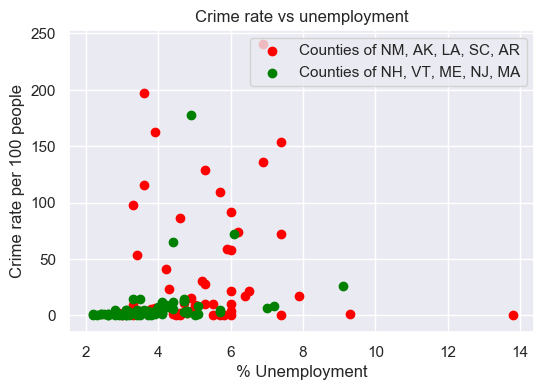

In [405]:
# Crime rate vs unemployment
plt.figure(dpi = 100)
plt.scatter(worst_df['Unemployment Rate'], worst_df['total-crime-per100'], c = 'red', label = 'Counties of NM, AK, LA, SC, AR')
plt.scatter(best_df['Unemployment Rate'], best_df['total-crime-per100'], c = 'green', label = 'Counties of NH, VT, ME, NJ, MA')
plt.title('Crime rate vs unemployment')
plt.xlabel('% Unemployment')
plt.ylabel('Crime rate per 100 people')
plt.legend()
plt.show()

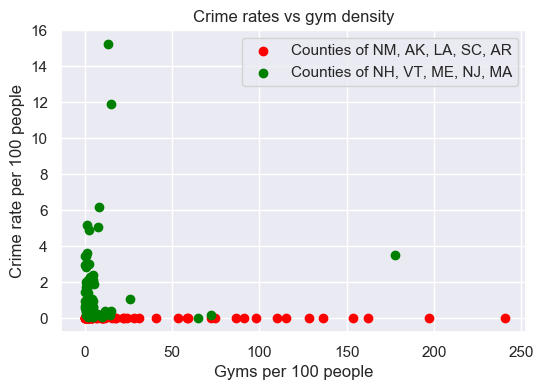

In [406]:
# Crime rate vs gym density
plt.figure(dpi = 100)
plt.scatter(worst_df['total-crime-per100'], worst_df['gym-per100'], c = 'red', label = 'Counties of NM, AK, LA, SC, AR')
plt.scatter(best_df['total-crime-per100'], best_df['gym-per100'], c = 'green', label = 'Counties of NH, VT, ME, NJ, MA')
plt.title('Crime rates vs gym density')
plt.xlabel('Gyms per 100 people')
plt.ylabel('Crime rate per 100 people')
plt.legend()
plt.show()

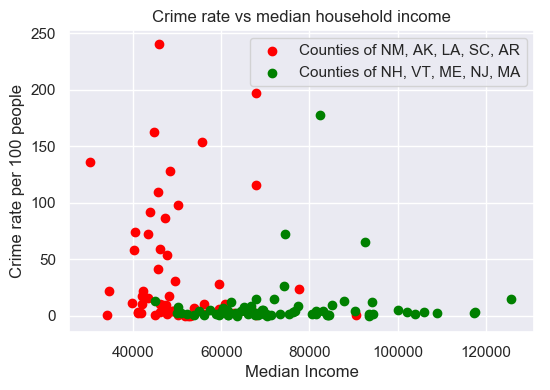

In [407]:
# Crime rate vs Median household income
plt.figure(dpi = 100)
plt.scatter(worst_df['MedianIncome'], worst_df['total-crime-per100'], c = 'red', label = 'Counties of NM, AK, LA, SC, AR')
plt.scatter(best_df['MedianIncome'], best_df['total-crime-per100'], c = 'green', label = 'Counties of NH, VT, ME, NJ, MA')
plt.title('Crime rate vs median household income')
plt.xlabel('Median Income')
plt.ylabel('Crime rate per 100 people')
plt.legend()
plt.show()